In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models
import torchvision.transforms as transforms
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# hyper parameters
num_epochs = 3
num_classes = 10
batch_size = 100
learning_rate = 0.001

In [3]:
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./data',
                                           train=True,
                                           transform=transforms.ToTensor(),
                                           download=True)
test_dataset = torchvision.datasets.MNIST(root='./data',
                                          train=False,
                                          transform=transforms.ToTensor())

# data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [4]:
class ConvNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        # note: reshape right before the first fc layer
        # size(0) is the number of elements in the tensor, example:
            # a = torch.tensor([2, 3, 4, 5])
            # print(a.size(0)) # 4
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

model = ConvNet(num_classes).to(device)


In [5]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
train_step = len(train_loader) # total number of `i`

for epoch in range(num_epochs): # repeat the entire training `num_epochs` times
    # for each training sample
    for i, (images, labels) in enumerate(train_loader):
        # move to gpu if available
        images = images.to(device)
        labels = labels.to(device)
        # forward pass
        outputs = model(images)
        loss = criterion(outputs, labels) # still a tensor so we need to use .item() when printing
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # print
        if (i+1) % 100 == 0:
            print('Epoch: [{}/{}], Step[{}/{}], Loss:{:.4f}' \
                  .format(epoch+1, num_epochs, i+1, train_step, loss.item()))

Epoch: [1/3], Step[100/600], Loss:0.2692
Epoch: [1/3], Step[200/600], Loss:0.1120
Epoch: [1/3], Step[300/600], Loss:0.0802
Epoch: [1/3], Step[400/600], Loss:0.0648
Epoch: [1/3], Step[500/600], Loss:0.0901
Epoch: [1/3], Step[600/600], Loss:0.0817
Epoch: [2/3], Step[100/600], Loss:0.0724
Epoch: [2/3], Step[200/600], Loss:0.0757
Epoch: [2/3], Step[300/600], Loss:0.0043
Epoch: [2/3], Step[400/600], Loss:0.0388
Epoch: [2/3], Step[500/600], Loss:0.0081
Epoch: [2/3], Step[600/600], Loss:0.0121
Epoch: [3/3], Step[100/600], Loss:0.0370
Epoch: [3/3], Step[200/600], Loss:0.0249
Epoch: [3/3], Step[300/600], Loss:0.0372
Epoch: [3/3], Step[400/600], Loss:0.0261
Epoch: [3/3], Step[500/600], Loss:0.0369
Epoch: [3/3], Step[600/600], Loss:0.0828


In [7]:
# Test set
model.eval() # BatchNorm uses moving mean/variance instead of mini-batch mean/variance

with torch.no_grad():
    # initialize the stats
    correct = 0
    total = 0
    # pass through testing data once
    for images, labels in test_loader:
        # again move to device first
        images = images.to(device)
        labels = labels.to(device)
        # forward once
        outputs = model(images)
        # instead of calculating loss we will get predictions
        # it's essetially outputs just reformatting imo
        _, predicted = torch.max(outputs.data, 1)
        # accumulate stats
        total += labels.size(0) # yeah again, number of elements in the tensor
        correct += (labels == predicted).sum().item() 

    # print
    print('Test accuracy on 10000 test images: {}%' \
            .format(100 * correct / total))

# save model checkpoint
torch.save(model.state_dict(), 'cnn.ckpt')

Test accuracy on 10000 test images: 98.89%


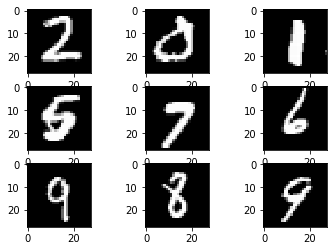

In [9]:
"""""
display some of the raw mnist data
"""""


import matplotlib.pyplot as plt
#for a 100 image mini batch
for i, (images, labels) in enumerate(train_loader):
    #just do the first x batches
    if(i > 0):
        break
    #prepare and load images
    images = images.to(device)
    labels = labels.to(device)    
    
    #for the first image in each batch
    for j in range(9):#images.shape[0]):
        # define subplot
        plt.subplot(330 + 1 + j)
        # plot raw pixel data
        batch_img = images[j]
        plt.imshow(batch_img[0], cmap=plt.get_cmap('gray'))
    # show the figure
    plt.show()

In [13]:
"""""
create new test sets (and train sets)
"""""

import numpy as np

#load full test dataset
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=10000,
                                          shuffle=False)

image_matrix = np.zeros(shape=(10000,1, 28, 28))
labels_matrix = np.zeros(shape=(10000,))
noisy_1 = np.zeros(shape=(10000, 1, 28, 28))
noisy_2 = np.zeros(shape=(10000, 1, 28, 28))
noisy_3 = np.zeros(shape=(10000, 1, 28, 28))
noisy_4 = np.zeros(shape=(10000, 1, 28, 28))

#for a 100 image mini batch
for i, (images, labels) in enumerate(test_loader):
    #just do the first x batches
    if(i > 2):
        break
    #prepare and load images
    images = images.to(device)
    
    #for the first image in each batch, or for all of them
    for j in range(images.shape[0]):
        batch_img = images[j]
        
        noise_1 = np.random.normal(loc=0.0, scale=0.025, size=batch_img.shape)
        noise_2 = np.random.normal(loc=0.0, scale=0.05, size=batch_img.shape)
        noise_3 = np.random.normal(loc=0.0, scale=0.1, size=batch_img.shape)
        noise_4 = np.random.normal(loc=0.0, scale=0.2, size=batch_img.shape)

        batch_img_1 = batch_img + noise_1
        batch_img_2 = batch_img + noise_2
        batch_img_3 = batch_img + noise_3
        batch_img_4 = batch_img + noise_4

        labels_matrix[j] = labels[j] 
        image_matrix[j] = batch_img[0]
        noisy_1[j] = batch_img_1
        noisy_2[j] = batch_img_2
        noisy_3[j] = batch_img_3
        noisy_4[j] = batch_img_4

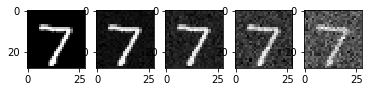

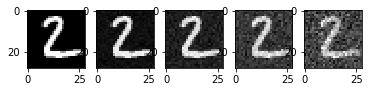

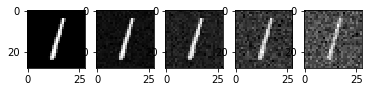

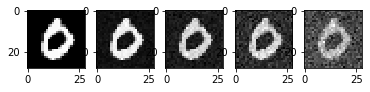

In [16]:
""""
display the data that has been changed and compare to original data
"""


for i, (images, labels) in enumerate(test_loader):
    images = images.to(device)
    
    numelems = 4 #use images.shape[0] to get the whole dataset
    for j in range(numelems):
        batch_img = images[j]
        noisy_1_img = noisy_1[j];
        noisy_2_img = noisy_2[j];
        noisy_3_img = noisy_3[j];
        noisy_4_img = noisy_4[j];
        
        for k in range(5):
            if k == 0:
                plt.subplot(1,5,k+1)
                plt.imshow(batch_img[0], cmap=plt.get_cmap('gray')) 
            if k == 1:
                plt.subplot(1,5,k+1)
                plt.imshow(noisy_1_img[0], cmap=plt.get_cmap('gray'))
            if k == 2:
                plt.subplot(1,5,k+1)
                plt.imshow(noisy_2_img[0], cmap=plt.get_cmap('gray'))
            if k == 3:
                plt.subplot(1,5,k+1)
                plt.imshow(noisy_3_img[0], cmap=plt.get_cmap('gray'))
            if k == 4:
                plt.subplot(1,5,k+1)
                plt.imshow(noisy_4_img[0], cmap=plt.get_cmap('gray'))                
        plt.savefig('noisy_images.png')
        plt.show()


Test accuracy on 10000 test images: 98.89%
Test accuracy on 10000 test images: 98.81%
Test accuracy on 10000 test images: 98.66%
Test accuracy on 10000 test images: 97.53%
Test accuracy on 10000 test images: 86.13%


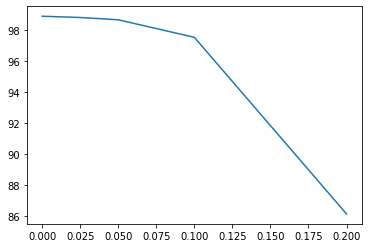

In [15]:
"""""
run the original model on each of these datasets
"""""

model.eval() # BatchNorm uses moving mean/variance instead of mini-batch mean/variance

no_noise_tensor = torch.Tensor(image_matrix)
noisy_test_1_tensor = torch.Tensor(noisy_1)
noisy_test_2_tensor = torch.Tensor(noisy_2)
noisy_test_3_tensor = torch.Tensor(noisy_3)
noisy_test_4_tensor = torch.Tensor(noisy_4)
labels_tensor = torch.Tensor(labels_matrix)


no_noise_dataset = torch.utils.data.TensorDataset(no_noise_tensor, labels_tensor)
noise_0_test_loader = torch.utils.data.DataLoader(dataset=no_noise_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)
noise_1_dataset = torch.utils.data.TensorDataset(noisy_test_1_tensor, labels_tensor)
noise_1_test_loader = torch.utils.data.DataLoader(dataset=noise_1_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)
noise_2_dataset = torch.utils.data.TensorDataset(noisy_test_2_tensor, labels_tensor)
noise_2_test_loader = torch.utils.data.DataLoader(dataset=noise_2_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)
noise_3_dataset = torch.utils.data.TensorDataset(noisy_test_3_tensor, labels_tensor)
noise_3_test_loader = torch.utils.data.DataLoader(dataset=noise_3_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)
noise_4_dataset = torch.utils.data.TensorDataset(noisy_test_4_tensor, labels_tensor)
noise_4_test_loader = torch.utils.data.DataLoader(dataset=noise_4_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

err1 = 0
err2 = 0
err3 = 0
err4 = 0
err5 = 0

with torch.no_grad():
    # initialize the stats
    correct = 0
    total = 0
    # pass through testing data once
    for images, labels in noise_0_test_loader:
        # again move to device first
        images = images.to(device)
        labels = labels.to(device)
        # forward once
        outputs = model(images)
        # instead of calculating loss we will get predictions
        # it's essetially outputs just reformatting imo
        _, predicted = torch.max(outputs.data, 1)
        # accumulate stats
        total += labels.size(0) # yeah again, number of elements in the tensor
        correct += (labels == predicted).sum().item() 

    # print
    print('Test accuracy on 10000 test images: {}%' \
            .format(100 * correct / total))
    err1 = 100 * correct / total

with torch.no_grad():
    # initialize the stats
    correct = 0
    total = 0
    # pass through testing data once
    for images, labels in noise_1_test_loader:
        # again move to device first
        images = images.to(device)
        labels = labels.to(device)
        # forward once
        outputs = model(images)
        # instead of calculating loss we will get predictions
        # it's essetially outputs just reformatting imo
        _, predicted = torch.max(outputs.data, 1)
        # accumulate stats
        total += labels.size(0) # yeah again, number of elements in the tensor
        correct += (labels == predicted).sum().item() 

    # print
    print('Test accuracy on 10000 test images: {}%' \
            .format(100 * correct / total))
    err2 = 100 * correct / total

with torch.no_grad():
    # initialize the stats
    correct = 0
    total = 0
    # pass through testing data once
    for images, labels in noise_2_test_loader:
        # again move to device first
        images = images.to(device)
        labels = labels.to(device)
        # forward once
        outputs = model(images)
        # instead of calculating loss we will get predictions
        # it's essetially outputs just reformatting imo
        _, predicted = torch.max(outputs.data, 1)
        # accumulate stats
        total += labels.size(0) # yeah again, number of elements in the tensor
        correct += (labels == predicted).sum().item() 

    # print
    print('Test accuracy on 10000 test images: {}%' \
            .format(100 * correct / total))
    err3 = 100 * correct / total


with torch.no_grad():
    # initialize the stats
    correct = 0
    total = 0
    # pass through testing data once
    for images, labels in noise_3_test_loader:
        # again move to device first
        images = images.to(device)
        labels = labels.to(device)
        # forward once
        outputs = model(images)
        # instead of calculating loss we will get predictions
        # it's essetially outputs just reformatting imo
        _, predicted = torch.max(outputs.data, 1)
        # accumulate stats
        total += labels.size(0) # yeah again, number of elements in the tensor
        correct += (labels == predicted).sum().item() 

    # print
    print('Test accuracy on 10000 test images: {}%' \
            .format(100 * correct / total))    
    err4 = 100 * correct / total

    
with torch.no_grad():
    # initialize the stats
    correct = 0
    total = 0
    # pass through testing data once
    for images, labels in noise_4_test_loader:
        # again move to device first
        images = images.to(device)
        labels = labels.to(device)
        # forward once
        outputs = model(images)
        # instead of calculating loss we will get predictions
        # it's essetially outputs just reformatting imo
        _, predicted = torch.max(outputs.data, 1)
        # accumulate stats
        total += labels.size(0) # yeah again, number of elements in the tensor
        correct += (labels == predicted).sum().item() 

    # print
    print('Test accuracy on 10000 test images: {}%' \
            .format(100 * correct / total))    
    err5 = 100 * correct / total
    
# save model checkpoint
#torch.save(model.state_dict(), 'cnn.ckpt')

plt.plot([0, 0.025, 0.05, 0.1, 0.2], [err1, err2, err3, err4, err5])
plt.savefig('noise_accuracy.png')
